In [10]:
# Importações necessárias
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Definindo ação, intervalo e período
stock = 'AAPL'
interval = '1m'

# Definindo o período de treinamento (dados históricos)
train_start = '2024-03-04'
train_end = '2024-03-09'

# Definindo o período de teste (dados futuros)
test_start = '2024-03-11'
test_end = '2024-03-16'

# Download dos dados treinamento
train_data = yf.download(stock, start=train_start, end=train_end, interval=interval)

# Download dos dados futuros para teste
test_data = yf.download(stock, start=test_start, end=test_end, interval=interval)

if not train_data.empty and not test_data.empty:
    # Cálculo das moving averages como features adicionais para os dados de treinamento
    train_data['MA_1'] = train_data['Close'].rolling(window=1).mean()
    train_data['MA_2'] = train_data['Close'].rolling(window=2).mean()
    train_data['MA_7'] = train_data['Close'].rolling(window=7).mean()

    # Adicionando média da abertura dos 3 minutos anteriores para os dados de treinamento
    train_data['Avg_Open_7min'] = train_data['Open'].rolling(window=7).mean()
    train_data['Avg_Open_7min'] = train_data['Avg_Open_7min'].shift(1)

    # Removendo possíveis NaNs dos dados de treinamento
    train_data.dropna(inplace=True)

    # Cálculo das moving averages como features adicionais para os dados de teste
    test_data['MA_1'] = test_data['Close'].rolling(window=1).mean()
    test_data['MA_2'] = test_data['Close'].rolling(window=2).mean()
    test_data['MA_7'] = test_data['Close'].rolling(window=7).mean()

    # Adicionando média da abertura dos 7 minutos anteriores para os dados de teste
    test_data['Avg_Open_7min'] = test_data['Open'].rolling(window=7).mean()
    test_data['Avg_Open_7min'] = test_data['Avg_Open_7min'].shift(1)

    # Removendo valores nulos
    test_data.dropna(inplace=True)

    # Normalização dos dados de treinamento e teste
    scaler_train = MinMaxScaler(feature_range=(0, 1))
    train_data_scaled = scaler_train.fit_transform(train_data[['Close', 'MA_1', 'MA_7', 'Avg_Open_7min']])
    scaler_test = MinMaxScaler(feature_range=(0, 1))
    test_data_scaled = scaler_test.fit_transform(test_data[['Close', 'MA_1', 'MA_7', 'Avg_Open_7min']])

    # Dados para treinar
    def create_dataset(dataset, time_step=7):
        x, y = [], []
        for i in range(time_step, len(dataset)):
            x.append(dataset[i-time_step:i, :])
            y.append(dataset[i, 0])
        return np.array(x), np.array(y)

    time_step = 7
    
    # Dados para treino
    x_train, y_train = create_dataset(train_data_scaled, time_step)

    # Dados para teste
    x_test, y_test = create_dataset(test_data_scaled, time_step)



[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


In [11]:
# Definindo a arquitetura do modelo
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(time_step, 4)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

# Compilando e treinando
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
60/60 - 3s - loss: 0.0205 - 3s/epoch - 52ms/step
Epoch 2/100
60/60 - 0s - loss: 0.0032 - 493ms/epoch - 8ms/step
Epoch 3/100
60/60 - 1s - loss: 0.0031 - 501ms/epoch - 8ms/step
Epoch 4/100
60/60 - 0s - loss: 0.0025 - 470ms/epoch - 8ms/step
Epoch 5/100
60/60 - 1s - loss: 0.0027 - 506ms/epoch - 8ms/step
Epoch 6/100
60/60 - 0s - loss: 0.0026 - 475ms/epoch - 8ms/step
Epoch 7/100
60/60 - 0s - loss: 0.0024 - 484ms/epoch - 8ms/step
Epoch 8/100
60/60 - 0s - loss: 0.0022 - 468ms/epoch - 8ms/step
Epoch 9/100
60/60 - 0s - loss: 0.0023 - 488ms/epoch - 8ms/step
Epoch 10/100
60/60 - 0s - loss: 0.0027 - 490ms/epoch - 8ms/step
Epoch 11/100
60/60 - 0s - loss: 0.0024 - 499ms/epoch - 8ms/step
Epoch 12/100
60/60 - 0s - loss: 0.0019 - 459ms/epoch - 8ms/step
Epoch 13/100
60/60 - 0s - loss: 0.0022 - 497ms/epoch - 8ms/step
Epoch 14/100
60/60 - 0s - loss: 0.0020 - 472ms/epoch - 8ms/step
Epoch 15/100
60/60 - 1s - loss: 0.0020 - 508ms/epoch - 8ms/step
Epoch 16/100
60/60 - 1s - loss: 0.0018 - 515ms/epoc

In [12]:
predictions = model.predict(x_test)
# Criando uma matriz temporária com a mesma estrutura que os dados originais
temp_predictions = np.zeros((len(predictions), test_data_scaled.shape[1]))
# Preenchendo apenas a primeira coluna com as previsões 
temp_predictions[:, 0] = predictions.ravel()  

# Aplicando inverse_transform nessa matriz temporária
predicted_stock_price = scaler_test.inverse_transform(temp_predictions)[:, 0]
real_stock_price = scaler_test.inverse_transform(test_data_scaled[time_step:, :])[:, 0]

# Avaliação dos resultados
mse = mean_squared_error(real_stock_price, predicted_stock_price)
r2 = r2_score(real_stock_price, predicted_stock_price)
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
rmse = np.sqrt(mse)

print(f'MSE: {mse}, R2: {r2}, MAE: {mae}, RMSE: {rmse} ')


61/61 [==============================] - 1s 5ms/step
MSE: 0.015693014812739083, R2: 0.9835870702536137, MAE: 0.089298502230666, RMSE: 0.1252717638286421 


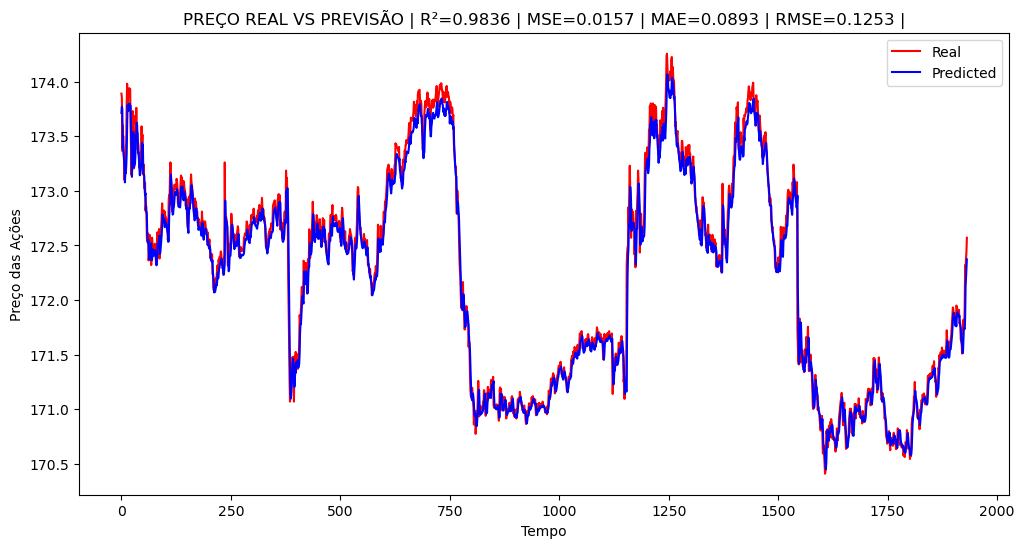

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(real_stock_price, color='red', label='Real')
plt.plot(predicted_stock_price, color='blue', label='Predicted')
plt.title(f'PREÇO REAL VS PREVISÃO | R²={r2:.4f} | MSE={mse:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f} |')
plt.xlabel('Tempo')
plt.ylabel('Preço das Ações')
plt.legend()
plt.show()

In [9]:
# Criando DataFrame com valores reais e previstos
results_df = pd.DataFrame({'Valor Real': real_stock_price, 'Previsão': predicted_stock_price})
results_df['Diferença'] = ((results_df['Previsão'] - results_df['Valor Real']) / results_df['Valor Real']) * 100

# Exibindo as primeiras linhas do DataFrame
print(results_df.head(20))

    Valor Real    Previsão  Diferença
0   173.889893  173.679727  -0.120861
1   173.854996  173.739917  -0.066193
2   173.365005  173.713126   0.200802
3   173.600006  173.347940  -0.145200
4   173.410004  173.496312   0.049771
5   173.350006  173.303241  -0.026977
6   173.317795  173.268578  -0.028397
7   173.100006  173.225235   0.072345
8   173.270004  173.061004  -0.120621
9   173.240005  173.166921  -0.042187
10  173.330002  173.142376  -0.108248
11  173.464996  173.214463  -0.144429
12  173.779999  173.319790  -0.264823
13  173.979996  173.569950  -0.235686
14  173.860001  173.750831  -0.062792
15  173.800003  173.704885  -0.054729
16  173.914993  173.687759  -0.130658
17  173.925003  173.757576  -0.096264
18  173.940002  173.755041  -0.106336
19  173.919998  173.768767  -0.086954
